# Convolutional Neural Network Classification For Hand Poses
This script shows how to build a convolutional neural network to classify different hand poses.

## Import Libraries

In [14]:
# import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import random, shutil
import imageio.v3 as imageio
from datetime import datetime

In [13]:
!ls data/train

# define the number of output K
num_classes = len(os.listdir('data/train'))
print(f"The number of classes: {num_classes}")

down  fist  left  right  up
The number of classes: 5


## Organize Data

In [3]:
# create folder environments for training and testing
os.makedirs(name="data", exist_ok=True)

os.makedirs(name="data/train", exist_ok=True)
os.makedirs(name="data/test", exist_ok=True)

os.makedirs(name="data/train/fist", exist_ok=True)      # label 0 for training
os.makedirs(name="data/train/up", exist_ok=True)        # label 1 for training
os.makedirs(name="data/train/left", exist_ok=True)      # label 2 for training
os.makedirs(name="data/train/down", exist_ok=True)      # label 3 for training
os.makedirs(name="data/train/right", exist_ok=True)     # label 4 for training

os.makedirs(name="data/test/fist", exist_ok=True)       # label 0 for testing
os.makedirs(name="data/test/up", exist_ok=True)         # label 1 for testing
os.makedirs(name="data/test/left", exist_ok=True)       # label 2 for testing
os.makedirs(name="data/test/down", exist_ok=True)       # label 3 for testing
os.makedirs(name="data/test/right", exist_ok=True)      # label 4 for testing

In [4]:
# randomly move image files from train to test folder
def random_file_move(label_name: str, ratio=0.2):
    # label_name: fist, up, left, down, right
    src = f"data/train/{label_name}/"
    dst = f"data/test/{label_name}/"
    
    # check whether the ratio between train and test image files
    files_src = os.listdir(src)
    files_dst = os.listdir(dst)
    n_files_to_move = round((len(files_src) + len(files_dst)) * ratio)
    if n_files_to_move <= len(files_dst):
        # if the number of dst files is greater than or equal to the ratio of the number of total files
        # consider the files are already moved from train to test folder
        return
    # else move the files to meet the ratio
    n_files_to_move -= len(files_dst)
    for file_name in random.sample(files_src, n_files_to_move):
        shutil.move(os.path.join(src, file_name), dst)

random_file_move("fist")
random_file_move("up")
random_file_move("left")
random_file_move("down")
random_file_move("right")

## Load Data

In [5]:
# define data transformer for train and test set
# we can also introduce data augmentation for training if needed
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])

In [6]:
# load train and test dataset
train_dataset = datasets.ImageFolder(
    root='data/train',
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root='data/test',
    transform=test_transform
)

## Preprocess Data

In [9]:
# dataloader to automatically generate batches in the training loop with shuffling
batch_size = 3
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size
)

In [10]:
# understand DataLoader better
tmp_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=1,
    shuffle=True
)

for x, y in tmp_loader:
    print(x)
    print(x.shape)
    print(y)
    print(y.shape)
    break

tensor([[[[0.5137, 0.5020, 0.4784,  ..., 0.2824, 0.2980, 0.2824],
          [0.5020, 0.5020, 0.4863,  ..., 0.2784, 0.2863, 0.2745],
          [0.5020, 0.5020, 0.4784,  ..., 0.2863, 0.2745, 0.2706],
          ...,
          [0.3725, 0.3922, 0.3647,  ..., 0.2824, 0.2627, 0.2863],
          [0.3843, 0.4039, 0.3725,  ..., 0.2784, 0.2549, 0.2667],
          [0.4118, 0.4118, 0.3725,  ..., 0.2784, 0.2745, 0.2863]],

         [[0.4078, 0.3961, 0.4196,  ..., 0.2275, 0.2510, 0.2353],
          [0.3961, 0.3961, 0.4078,  ..., 0.2353, 0.2471, 0.2353],
          [0.3961, 0.3961, 0.4118,  ..., 0.2431, 0.2314, 0.2275],
          ...,
          [0.2980, 0.3176, 0.3373,  ..., 0.2431, 0.2275, 0.2510],
          [0.2941, 0.3137, 0.3294,  ..., 0.2471, 0.2353, 0.2471],
          [0.3098, 0.3098, 0.3176,  ..., 0.2471, 0.2431, 0.2549]],

         [[0.4196, 0.4078, 0.4157,  ..., 0.2118, 0.1804, 0.1647],
          [0.4078, 0.4078, 0.4118,  ..., 0.2078, 0.2000, 0.1882],
          [0.4078, 0.4078, 0.4118,  ..., 0

## Build Model

In [16]:
# define the model
class CNN(nn.Module):
    def __init__(self, num_classes):
        # K is the number of output classes
        super(CNN, self).__init__()
        
        # define pooling layer
        # max pool with (2X2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # define convolution layers
        # convolutional layer 1 -> input: (3, 360, 640), output: (16, 180, 320) after pooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        # convolutional layer 2 -> input: (16, 180, 320), output: (32, 90, 160) after pooling
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # convolutional layer 3 -> input: (32, 90, 160), output: (64, 45, 80) after pooling
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # convolutional layer 4 -> input: (64, 45, 80), output: (128, 22, 40) after pooling
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # define dropout layer after convolutional layers
        self.dropout_conv = nn.Dropout(p=0.2)
        
        # define fully connected layers
        # fully connected layer 1 -> flattened the input to 512 neurons
        self.fc1 = nn.Linear(128 * 22 * 40, 512)
        # fully connected layer 2 -> 512 to number of classes 
        self.fc2 = nn.Linear(512, num_classes)
        
        # define dropout layer after fully connected layers
        self.dropout_fc = nn.Dropout(p=0.5)
        
    def forward(self, X):
        # apply convolutional layer -> relu -> pooling
        X = self.pool(F.relu(self.conv1(X)))    # (3, 360, 640) -> (16, 180, 320)
        X = self.pool(F.relu(self.conv2(X)))    # (16, 180, 320) -> (32, 90, 160)
        X = self.pool(F.relu(self.conv3(X)))    # (32, 90, 160) -> (64, 45, 80)
        X = self.pool(F.relu(self.conv4(X)))    # (64, 45, 80) -> (128, 22, 40)
        
        # apply dropout layer after convolutional layers
        X = self.dropout_conv(X)
        
        # flatten the output from convolutional layers
        X = X.view(-1, 128 * 22 * 40)
        
        # apply fully connected layers -> relu -> dropout
        X = F.relu(self.fc1(X))
        X = self.dropout_fc(X)
        X = self.fc2(X)
        
        # return the result
        return X

In [19]:
# instantiate the model
model = CNN(K)
print(model)

CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_conv): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=112640, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
  (dropout_fc): Dropout(p=0.5, inplace=False)
)


In [20]:
# activate gpu if possible, otherwise cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# send the model to the device
model.to(device)

cuda:0


CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout_conv): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=112640, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
  (dropout_fc): Dropout(p=0.5, inplace=False)
)

In [22]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training

In [24]:
# define batch gradient descent method for training
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    # losses will be stored to plot the results
    # storage for losses per each epoch
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    # epoch iteration
    for epoch in range(epochs):
        ## train mode
        model.train()
        t0 = datetime.now()
        train_loss = []
        
        # batch iteration
        for inputs, targets in train_loader:
            # send data to the device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # zero the parameter gradients to make sure they are zero
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # backward and optimize
            loss.backward()
            optimizer.step()
            
            # save the batch loss
            train_loss.append(loss.item())
            
        # get train loss per epoch as average loss of all the batches in that epoch
        train_loss = np.mean(train_loss)
        train_losses[epoch] = train_loss
        
        ## test mode
        model.eval()
        test_loss = []
        
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        
        test_loss = np.mean(test_loss)
        test_losses[epoch] = test_loss
        
        # calculate time spent per epoch
        dt = datetime.now() - t0
        
        # print out the result per epoch
        print(f"Epoch: {epoch+1}/{epochs}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Duration: {dt}")
    
    # return the results
    return train_losses, test_losses

In [25]:
# get the result
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=100
)

Epoch: 1/100, Train loss: 1.7504, Tess loss: 1.6139, Duration: 0:00:00.671095
Epoch: 2/100, Train loss: 1.6125, Tess loss: 1.6153, Duration: 0:00:00.363766
Epoch: 3/100, Train loss: 1.6115, Tess loss: 1.6139, Duration: 0:00:00.377126
Epoch: 4/100, Train loss: 1.6116, Tess loss: 1.6140, Duration: 0:00:00.354820
Epoch: 5/100, Train loss: 1.6114, Tess loss: 1.6142, Duration: 0:00:00.353515
Epoch: 6/100, Train loss: 1.6117, Tess loss: 1.6133, Duration: 0:00:00.358878
Epoch: 7/100, Train loss: 1.6107, Tess loss: 1.6134, Duration: 0:00:00.351731
Epoch: 8/100, Train loss: 1.6099, Tess loss: 1.6134, Duration: 0:00:00.355126
Epoch: 9/100, Train loss: 1.6074, Tess loss: 1.6135, Duration: 0:00:00.364297
Epoch: 10/100, Train loss: 1.6076, Tess loss: 1.6143, Duration: 0:00:00.351347
Epoch: 11/100, Train loss: 1.6077, Tess loss: 1.6141, Duration: 0:00:00.372047
Epoch: 12/100, Train loss: 1.6105, Tess loss: 1.6140, Duration: 0:00:00.352228
Epoch: 13/100, Train loss: 1.6097, Tess loss: 1.6141, Duratio

## Result

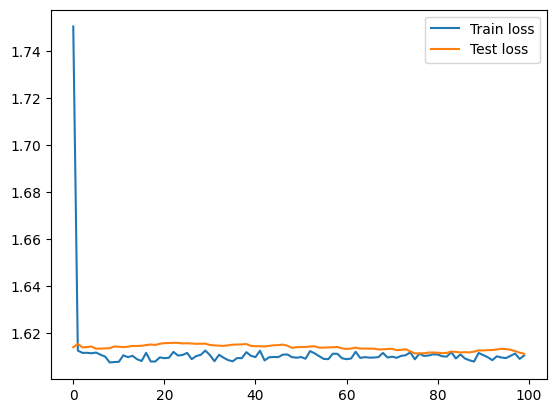

In [26]:
# plot the train loss and test loss per epoch
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()

In [30]:
# calculate accuracy
## train accuracy
n_correct = float(0)
n_total = float(0)

model.eval()
for inputs, targets in train_loader:
    # send data to the device
    inputs, targets = inputs.to(device), targets.to(device)
    
    # forward pass
    outputs = model(inputs)
    
    # predictions by returning max value label
    _, predictions = torch.max(outputs, 1)
    
    # update numbers
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
    
# calculate train accuracy
train_acc = n_correct / n_total
print(f"The number of train images: {n_total}")

## test accuracy
n_correct = float(0)
n_total = float(0)

model.eval()
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
    
# calculate train accuracy
test_acc = n_correct / n_total
print(f"The number of test images: {n_total}")

# print the result
print(f"Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")

The number of train images: 40.0
The number of test images: 10.0
Train accuracy: 0.2000, Test accuracy: 0.2000
